In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ufo-data-scrubbed-preprocessed/ufo_comments_cleaned.csv
/kaggle/input/ufo-data-scrubbed-preprocessed/ufo_data_scrubbed_preprocessed.csv


In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix

In [2]:
ufo_data = pd.read_csv("/kaggle/input/ufo-data-scrubbed-preprocessed/ufo_data_scrubbed_preprocessed.csv")
ufo_data.head()

,Unnamed: 0,datetime,city,state,country,shape,duration_seconds,duration_hours_min,comments,date posted,latitude,longitude,year
0,0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700.0,45 minutes,This event took place in early fall around 194...,2004-04-27,29.883056,-97.941111,1949
1,1,1949-10-10 21:00:00,lackland afb,tx,Unknown,light,7200.0,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,2005-12-16,29.384210,-98.581082,1949
2,2,1955-10-10 17:00:00,chester (uk/england),Unknown,gb,circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...,2008-01-21,53.200000,-2.916667,1955
3,3,1956-10-10 21:00:00,edna,tx,us,circle,20.0,1/2 hour,My older brother and twin sister were leaving ...,2004-01-17,28.978333,-96.645833,1956
4,4,1960-10-10 20:00:00,kaneohe,hi,us,light,900.0,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,2004-01-22,21.418056,-157.803611,1960


In [3]:
ufo_data_grouped = ufo_data.groupby(['year', 'state', 'country']).size().reset_index(name='sightings_count')

In [5]:
ufo_data_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4834 entries, 0 to 4833
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   year             4834 non-null   int64 
 1   state            4834 non-null   object
 2   country          4834 non-null   object
 3   sightings_count  4834 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 151.2+ KB


In [4]:
ufo_data_grouped.head()

,year,state,country,sightings_count
0,1906,Unknown,Unknown,1
1,1910,mo,us,1
2,1910,tx,us,1
3,1916,Unknown,Unknown,1
4,1920,in,us,1


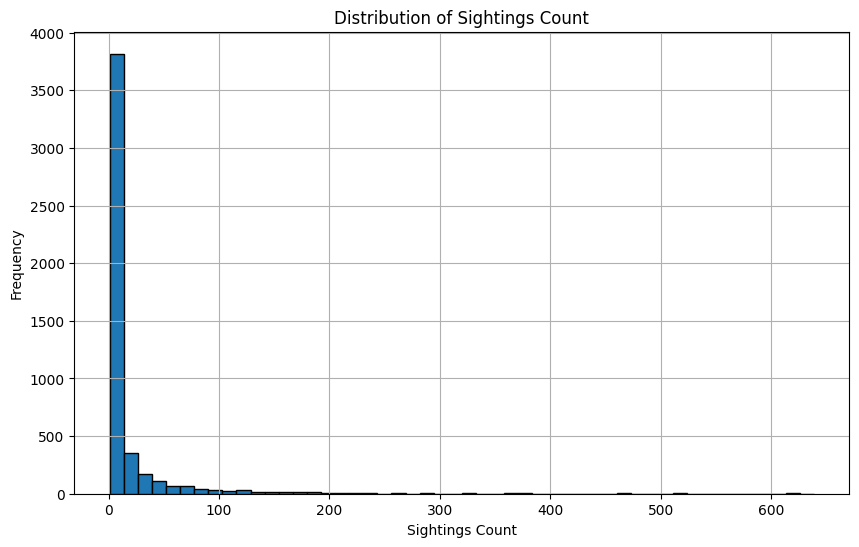

In [10]:
# Plot the distribution of sightings_count
plt.figure(figsize=(10, 6))
plt.hist(ufo_data_grouped['sightings_count'], bins=50, edgecolor='black')
plt.title('Distribution of Sightings Count')
plt.xlabel('Sightings Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [11]:
ufo_data_grouped_v2 = ufo_data.groupby(['year', 'state', 'country']).agg(
    sightings_count=('datetime', 'size'),
    avg_latitude=('latitude', 'mean'),
    avg_longitude=('longitude', 'mean'),
    most_common_shape=('shape', lambda x: x.mode()[0]),
    avg_duration_seconds=('duration_seconds', 'mean')
).reset_index()
ufo_data_grouped_v2.head()

,year,state,country,sightings_count,avg_latitude,avg_longitude,most_common_shape,avg_duration_seconds
0,1906,Unknown,Unknown,1,48.208174,16.373819,other,10800.0
1,1910,mo,us,1,40.194722,-92.583056,disk,120.0
2,1910,tx,us,1,32.709167,-96.008056,cigar,120.0
3,1916,Unknown,Unknown,1,46.227638,2.213749,cigar,60.0
4,1920,in,us,1,40.123889,-86.013333,unknown,60.0


In [12]:
ufo_data_grouped_cleaned = ufo_data_grouped_v2[~((ufo_data_grouped_v2['state'] == 'Unknown') & (ufo_data_grouped_v2['country'] == 'Unknown'))]

In [13]:
ufo_data_grouped_cleaned.head()

,year,state,country,sightings_count,avg_latitude,avg_longitude,most_common_shape,avg_duration_seconds
1,1910,mo,us,1,40.194722,-92.583056,disk,120.0
2,1910,tx,us,1,32.709167,-96.008056,cigar,120.0
4,1920,in,us,1,40.123889,-86.013333,unknown,60.0
5,1925,il,us,1,41.420833,-90.015000,disk,60.0
6,1929,or,us,1,43.642500,-118.627500,disk,60.0


In [14]:
ufo_data_grouped_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4764 entries, 1 to 4833
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  4764 non-null   int64  
 1   state                 4764 non-null   object 
 2   country               4764 non-null   object 
 3   sightings_count       4764 non-null   int64  
 4   avg_latitude          4764 non-null   float64
 5   avg_longitude         4764 non-null   float64
 6   most_common_shape     4764 non-null   object 
 7   avg_duration_seconds  4764 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 335.0+ KB


In [16]:
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(ufo_data_grouped_cleaned[['state', 'country', 'most_common_shape']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['state', 'country', 'most_common_shape']))

In [17]:
encoded_df.head()

,state_Unknown,state_ab,state_ak,state_al,state_ar,state_az,state_bc,state_ca,state_co,state_ct,...,most_common_shape_flash,most_common_shape_formation,most_common_shape_light,most_common_shape_other,most_common_shape_oval,most_common_shape_rectangle,most_common_shape_sphere,most_common_shape_teardrop,most_common_shape_triangle,most_common_shape_unknown
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
df_encoded = pd.concat([ufo_data_grouped_cleaned.drop(['state', 'country', 'most_common_shape'], axis=1), encoded_df], axis=1)

In [44]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4694 entries, 1 to 4763
Columns: 102 entries, year to most_common_shape_unknown
dtypes: float64(102)
memory usage: 3.7 MB


In [43]:
df_encoded = df_encoded.dropna()

In [45]:
X = df_encoded.drop('sightings_count', axis=1)
y = df_encoded['sightings_count']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [47]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=1000,),
    "XGBoost": XGBRegressor(random_state=42, max_depth=6, n_estimators=1000, nthread= 3),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "KNN": KNeighborsRegressor()
}

In [59]:
results = {}
for model_name, model in models.items():
    print(f"----------------------- {model_name} -----------------------")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    
    y_pred_class = y_pred.round().astype(int)
    
    accuracy = accuracy_score(y_test, y_pred_class)
    recall = recall_score(y_test, y_pred_class, average='weighted', labels=np.unique(y_pred_class))
    f1 = f1_score(y_test, y_pred_class, average='weighted', labels=np.unique(y_pred_class))
    precision = precision_score(y_test, y_pred_class,average='weighted', labels=np.unique(y_pred_class))
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    
    results[model_name] = {
        "RMSE": rmse,
        "MAE": mae,
        "Accuracy": accuracy,
        "Recall": recall,
        "F1-Score": f1,
        "Precision": precision
    }

----------------------- Linear Regression -----------------------
----------------------- Random Forest -----------------------


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------- XGBoost -----------------------
----------------------- Decision Tree -----------------------
----------------------- KNN -----------------------


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value}")
    print("\n")

Model: Linear Regression
RMSE: 43.983524689383344
MAE: 20.674503813074264
Accuracy: 0.022998296422487224
Recall: 0.02504638218923933
F1-Score: 0.030546097510453625
Precision: 0.14512471434377736


Model: Random Forest
RMSE: 30.97475804682944
MAE: 11.924151618398637
Accuracy: 0.2231686541737649
Recall: 0.23268206039076378
F1-Score: 0.2673607397832328
Precision: 0.34244003611294194


Model: XGBoost
RMSE: 34.05258348212555
MAE: 13.123519205124937
Accuracy: 0.08773424190800681
Recall: 0.09180035650623886
F1-Score: 0.12556704696479604
Precision: 0.25646190702116467


Model: Decision Tree
RMSE: 38.411771956943504
MAE: 13.195059625212947
Accuracy: 0.282793867120954
Recall: 0.2980251346499102
F1-Score: 0.29350369113752806
Precision: 0.2920743789909606


Model: KNN
RMSE: 43.35862652388194
MAE: 15.740715502555364
Accuracy: 0.227427597955707
Recall: 0.23754448398576514
F1-Score: 0.26422794115880804
Precision: 0.2984748386774079


